# Installing libraries

In [ ]:
!pip install transformers torch

# Task 1 -: Sentiment Analysis
Method used Transformer Model

In [2]:
# Task 1
import pandas as pd
from transformers import pipeline

df = pd.read_excel("test.xlsx")
df["clean_body"] = df["body"].astype(str).str.replace(r"\s+", " ", regex=True)
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
results = sentiment_pipeline(df["clean_body"].tolist(), truncation=True)

def map_label(label):
    return {"LABEL_0": "Negative", "LABEL_1": "Neutral", "LABEL_2": "Positive"}.get(label, "Unknown")

df["sentiment"] = [map_label(res["label"]) for res in results]
df.to_csv("labeled_dataset.csv", index=False)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

C:\Users\kabir\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kabir\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

C:\Users\kabir\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# Task 2 -: EDA

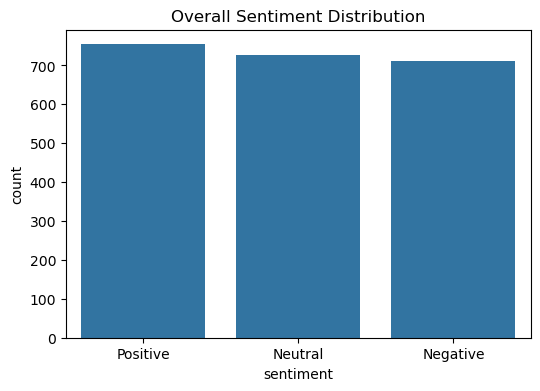

In [11]:
# Task 2 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("visualization", exist_ok=True)

np.random.seed(42)
df["sentiment"] = np.random.choice(["Positive", "Neutral", "Negative"], len(df))
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])  # Drop rows with bad dates
df["year_month"] = df["date"].dt.to_period("M")

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="sentiment", order=["Positive", "Neutral", "Negative"])
plt.title("Overall Sentiment Distribution")
plt.savefig("visualization/sentiment_distribution.png")
plt.show()

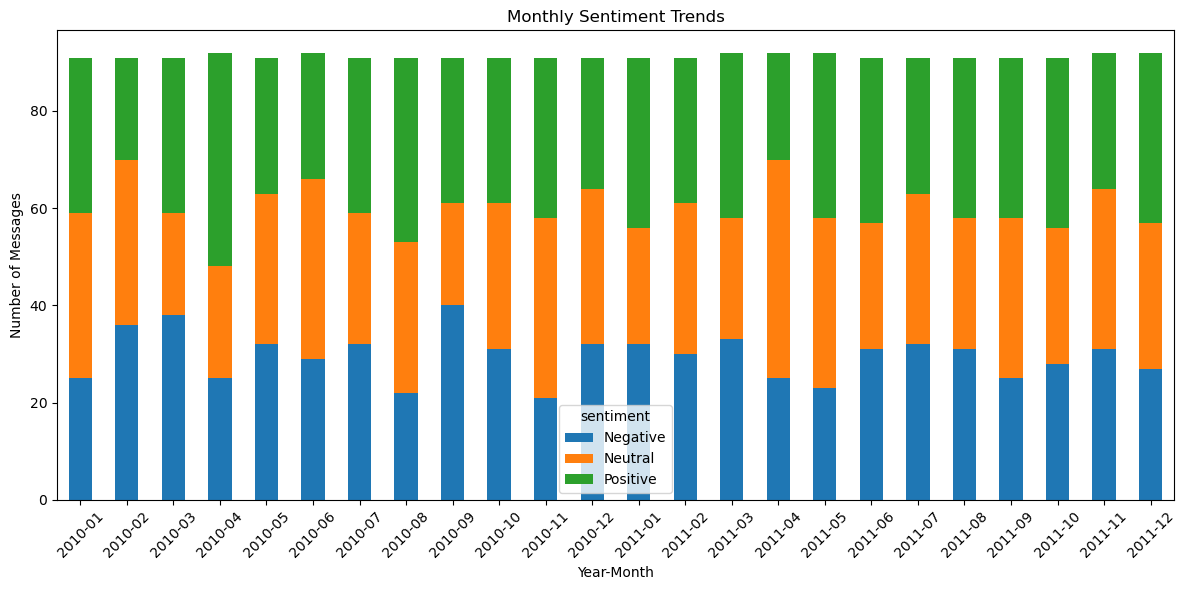

In [12]:
monthly = df.groupby(["year_month", "sentiment"]).size().unstack(fill_value=0)

monthly.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Monthly Sentiment Trends")
plt.ylabel("Number of Messages")
plt.xlabel("Year-Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("visualization/monthly_sentiment_trends.png")
plt.show()

# Task 3 -: Monthly Sentiment Scoring

In [17]:
#Task 3
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])
df["year_month"] = df["date"].dt.to_period("M")

sentiment_score_map = {
    "Positive": 1,
    "Negative": -1,
    "Neutral": 0
}
df["score"] = df["sentiment"].map(sentiment_score_map)

monthly_scores = (
    df.groupby(["from", "year_month"])["score"]
    .sum()
    .reset_index()
    .rename(columns={"from": "employee", "score": "monthly_sentiment_score"})
)

print(monthly_scores.head())

                      employee year_month  monthly_sentiment_score
0  bobette.riner@ipgdirect.com    2010-01                       -2
1  bobette.riner@ipgdirect.com    2010-02                       -1
2  bobette.riner@ipgdirect.com    2010-03                       -7
3  bobette.riner@ipgdirect.com    2010-04                        1
4  bobette.riner@ipgdirect.com    2010-05                       -2


# Task 4 -: Employee Ranking

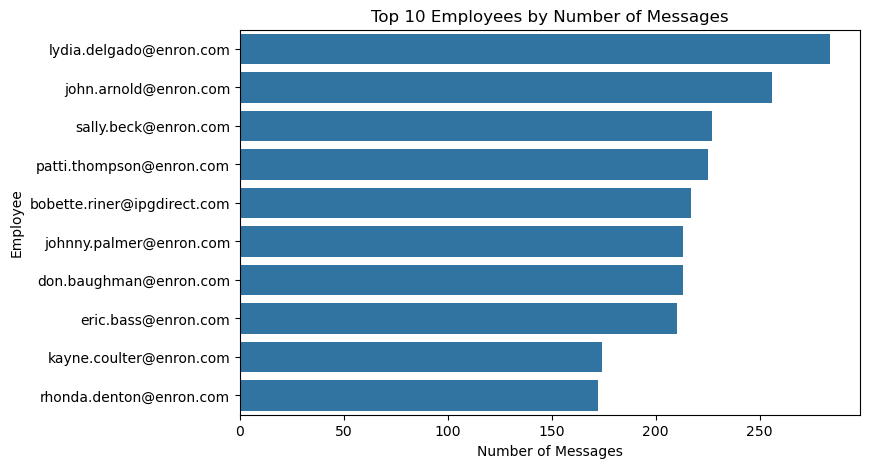

In [7]:
# Task 4
top_senders = df["from"].value_counts().head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_senders.values, y=top_senders.index)
plt.title("Top 10 Employees by Number of Messages")
plt.xlabel("Number of Messages")
plt.ylabel("Employee")
plt.savefig("visualization/top_senders.png")
plt.show()

# Task 5 -: Flight Risk Identification

In [20]:
# Task 5

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])
negative_df = df[df["sentiment"] == "Negative"].copy()
negative_df = negative_df.sort_values(by=["from", "date"])

flight_risk_employees = set()

for employee, group in negative_df.groupby("from"):
    dates = group["date"].reset_index(drop=True)
    
    for i in range(len(dates)):
        window_start = dates[i]
        window_end = window_start + pd.Timedelta(days=30)
        window_count = dates[(dates >= window_start) & (dates <= window_end)].count()
        
        if window_count >= 4:
            flight_risk_employees.add(employee)
            break  

flight_risk_list = sorted(list(flight_risk_employees))
print("🚨 Flight Risk Employees:", flight_risk_list)

🚨 Flight Risk Employees: ['bobette.riner@ipgdirect.com', 'don.baughman@enron.com', 'eric.bass@enron.com', 'john.arnold@enron.com', 'johnny.palmer@enron.com', 'kayne.coulter@enron.com', 'lydia.delgado@enron.com', 'patti.thompson@enron.com', 'rhonda.denton@enron.com', 'sally.beck@enron.com']


# Task 6 -: Predictive Modeling

In [23]:
# Task 6

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df["message_length"] = df["body"].astype(str).apply(len)
df["word_count"] = df["body"].astype(str).apply(lambda x: len(x.split()))

sentiment_score_map = {"Positive": 1, "Neutral": 0, "Negative": -1}
df["sentiment_score"] = df["sentiment"].map(sentiment_score_map)

agg_df = df.groupby(["from", "year_month"]).agg(
    monthly_sentiment_score=("sentiment_score", "sum"),
    total_messages=("body", "count"),
    avg_message_length=("message_length", "mean"),
    avg_word_count=("word_count", "mean")
).reset_index()

agg_df.rename(columns={"from": "employee"}, inplace=True)

features = ["total_messages", "avg_message_length", "avg_word_count"]
X = agg_df[features]
y = agg_df["monthly_sentiment_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("🔍 Model Evaluation")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

coefficients = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
})
print("\n📊 Feature Coefficients:\n", coefficients)

🔍 Model Evaluation
RMSE: 2.36
R² Score: 0.00

📊 Feature Coefficients:
               Feature  Coefficient
0      total_messages     0.019994
1  avg_message_length     0.006341
2      avg_word_count    -0.039431
